## MTH9893 Time Series Analysis HW4
* Group 01
* Author: Pan, Hongchao & Sun, Yu
* Kernel version: **R 3.3.2**
* **Packages: urca, vars,strucchange, readxl, sandwich, lmtest, tseries, MASS, repr and zoo**
* Data: End of day price of three front crude oil future contracts over past 5 years, i.e., CL1 Comdty, CL2 Comdty and CL3 Comdty.
* Notes: 
    * **Please install the packages listed above if your kernel does not have them** before running the notebook
    * Using ca.jo() function in package ***urca*** to retrive Johansen cointegration test
    * Using adf.test() function in package ***tseries*** for stationary test
    * No good package of Johansen cointegration test has been implemented in Python now
    
    * Test guildline:
        * Step 1: Test whether the time series are $I(1)$ or not
        * Step 2: Chose the lag of VAR(p) model, (also the parameter K in ca.jo() function)
        * Step 3: Johansen trace cointegration test
        * Step 4: Stationary test of VECM
        * Step 5: Find the cointegration matrix $a$
        * Step 6: Stationary test of "cointegrating residual process" $u_t=a^TX_t$
    
    * The running time of this notebook is around 2s

In [1]:
# install packages if does not have

#install.packages("urca")
# Does not work in the jupyter in macbook
# The above installation function retrive the package with .tar.gz, 
# but for macbook binraries it is .tgz and .zip for windows
# Thereore install the packages mannually with following steps:
# Step1: download corresponding binraries: .tgz or .zip
# Step2: unzip the binraries
# Step3: copy the folder to the R library under anaconda,
#        e.g., my location in Macbook is: ~/anaconda/lib/R/library
#              ~ standars for Users/your_user_name
# Step4: use the library as following way

#Same as urca
#install.packages("vars") 
#install.packages("tseries")
#install.packages("readxl")
#install.packages("sandwich")
#install.packages("strucchange")
#install.packages("lmtest")

In [2]:
# Load libraries
library(urca)
library(sandwich)    # vars required
library(zoo)         # sandwich required
library(MASS)     # vars required MASS
library(strucchange) # vars required
library(lmtest)      # vars required
library(vars)        # for VARselect() function
library(readxl)   # read_excel() function
library(repr)    # For changing plot features
library(tseries) # For ADF test


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [3]:
# Record the total running time of this notebook
# Starting record the time
ptm<-proc.time()

In [4]:
# Read the data form excel file
# Reference: https://cran.r-project.org/web/packages/readxl/readxl.pdf
df<- read_excel("CLs_Daily.xlsx",sheet = 1,col_names = TRUE, skip = 1)
colnames(df)<- c('Date','CL1_PX_LAST','Date2','CL2_PX_LAST','Date3','CL3_PX_LAST')
# Remove redundency date
vars<- c("Date","CL1_PX_LAST","CL2_PX_LAST","CL3_PX_LAST")
df_CLs<- df[vars]
head(df_CLs)

Date,CL1_PX_LAST,CL2_PX_LAST,CL3_PX_LAST
2012-03-02,106.70,107.17,107.64
2012-03-05,106.72,107.18,107.63
2012-03-06,104.70,105.21,105.75
2012-03-07,106.16,106.65,107.18
2012-03-08,106.58,107.06,107.56
2012-03-09,107.40,107.87,108.33


Table 1. Overview of end of day price of three front crude oil future contracts

In [5]:
# Compute the 1st order differential of three time series
CL1_diff1<- diff(df_CLs[,"CL1_PX_LAST"],differences = 1)
CL2_diff1<- diff(df_CLs[,"CL2_PX_LAST"],differences = 1)
CL3_diff1<- diff(df_CLs[,"CL3_PX_LAST"],differences = 1)
df_CLs_diff1<- data.frame(df_CLs[2:length(df_CLs[,"Date"]),"Date"],CL1_diff1,CL2_diff1,CL3_diff1)
colnames(df_CLs_diff1)<- c("Date","CL1_diff1","CL2_diff1","CL3_diff1")
head(df_CLs_diff1)

Date,CL1_diff1,CL2_diff1,CL3_diff1
2012-03-05,0.02,0.01,-0.01
2012-03-06,-2.02,-1.97,-1.88
2012-03-07,1.46,1.44,1.43
2012-03-08,0.42,0.41,0.38
2012-03-09,0.82,0.81,0.77
2012-03-12,-1.06,-1.03,-0.99


Table 2. Overview of 1st order differential of three front crude oil future contracts

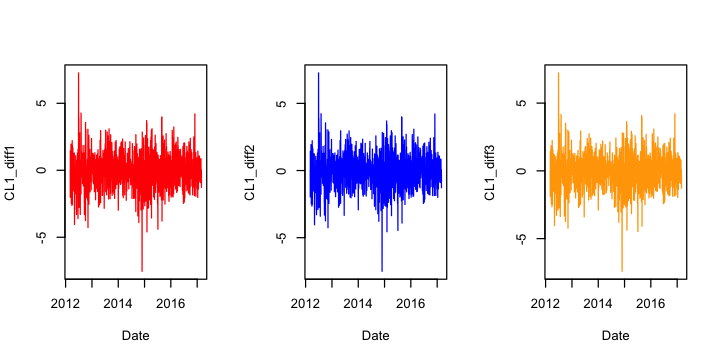

In [6]:
# Plot the 1st differential of CLs (returns)
options(repr.plot.height=3, repr.plot.width=6)
par(mfrow = c(1,3)) # combine the 4 plots in a 2 by 2 window filled by the row
plot(x=df_CLs_diff1[,'Date'],y=df_CLs_diff1[,"CL1_diff1"],type='l',
    xlab='Date',ylab='CL1_diff1',col='red')

plot(x=df_CLs_diff1[,'Date'],y=df_CLs_diff1[,"CL2_diff1"],type='l',
    xlab='Date',ylab='CL1_diff2',col='blue')

plot(x=df_CLs_diff1[,'Date'],y=df_CLs_diff1[,"CL3_diff1"],type='l',
    xlab='Date',ylab='CL1_diff3',col='orange')

Figure 1. Plots of 1st order differential of three front crude oil future contracts

**Observation:**
* The figure shows the returns of three time series are stationary, we can import ADF test to check

#### Stationary test of all three front crude oil future contracts and their 1st order differential

In [7]:
# ADF stationary test
adfCL1<- adf.test(df_CLs[,"CL1_PX_LAST"])
adfCL2<- adf.test(df_CLs[,"CL2_PX_LAST"])
adfCL3<- adf.test(df_CLs[,"CL3_PX_LAST"])
adfCL1diff<- adf.test(df_CLs_diff1[,"CL1_diff1"])
adfCL2diff<- adf.test(df_CLs_diff1[,"CL2_diff1"])
adfCL3diff<- adf.test(df_CLs_diff1[,"CL3_diff1"])

pval<- c(adfCL1$p.value,adfCL2$p.value,adfCL3$p.value,
        adfCL1diff$p.value,adfCL2diff$p.value,adfCL3diff$p.value)
TSname<-c("CL1","CL2","CL3","CL1_diff1","CL2_diff1","CL3_diff1")
CLsRes<- data.frame(TSname,pval)
colnames(CLsRes)<-c("TS Name","p-value")
CLsRes
#adfCL1
#adfCL2
#adfCL3
#adfCL1diff
#adfCL2diff
#adfCL3diff

Warning message in adf.test(df_CLs_diff1[, "CL1_diff1"]):
“p-value smaller than printed p-value”Warning message in adf.test(df_CLs_diff1[, "CL2_diff1"]):
“p-value smaller than printed p-value”Warning message in adf.test(df_CLs_diff1[, "CL3_diff1"]):
“p-value smaller than printed p-value”

TS Name,p-value
CL1,0.7869190
CL2,0.7764402
CL3,0.7760485
CL1_diff1,0.0100000
CL2_diff1,0.0100000
CL3_diff1,0.0100000


Table 3. ADF stationary test of three time series and their 1st order differential

**Observation:**

* The p-values of all three tests are much larger than 0.01, i.e., 99% confidence interval. Therefore, all the three front crude oil future contracts are non-stationary.

* The p-values of three 1st order differential time series are smaller than 0.01 (see warning messages).

* Therefore the three front crude oil future contracts are $I(1)$.

#### Choose the lag of VAR(p) model for the next Johansen cointegration test

* Reference: https://cran.r-project.org/web/packages/vars/vars.pdf 
* P47 VARselect() function

In [8]:
# Select the lag of VAR(p) model
# Set the maxlags=30, since the running time is fast due to 
# VARselect uses OLS not MLE
lagRes<- VARselect(df_CLs[,c("CL1_PX_LAST","CL2_PX_LAST","CL3_PX_LAST")],
                  lag.max=30)
lagRes

,1,2,3,4,5,6,7,8,9,10,⋯,21,22,23,24,25,26,27,28,29,30
AIC(n),-8.6204708619,-8.6792042482,-8.6821557484,-8.6815716386,-8.6788004698,-8.685347300,-8.6903872440,-8.6869865021,-8.686055795,-8.6798550684,⋯,-8.6325395928,-8.6348288625,-8.6771862967,-8.670338017,-8.6596282574,-8.6486315059,-8.640017385,-8.63040821,-8.6217141839,-8.6114308517
HQ(n),-8.6016967579,-8.6463495663,-8.6352204885,-8.6205558008,-8.6037040540,-8.596170306,-8.5871296722,-8.5696483524,-8.554637067,-8.5343557628,⋯,-8.3321539297,-8.3203626214,-8.3486394776,-8.327710620,-8.3029202824,-8.2778429529,-8.255148254,-8.23145851,-8.2086838970,-8.1843199868
SC(n),-8.5705706721,-8.5918789162,-8.5574052740,-8.5193960219,-8.4791997108,-8.448321398,-8.4159362004,-8.3751103163,-8.336754467,-8.2931285979,⋯,-7.8341365570,-7.7990006844,-7.8039329763,-7.759659555,-7.7115246524,-7.6631027585,-7.617063496,-7.57002918,-7.5239100096,-7.4762015351
FPE(n),0.0001803753,0.0001700864,0.0001695853,0.0001696846,0.0001701558,0.000169046,0.0001681968,0.0001687707,0.000168929,0.0001699811,⋯,0.0001782618,0.0001778616,0.0001704929,0.000171673,0.0001735308,0.0001754599,0.000176989,0.00017871,0.0001802836,0.0001821613


Table 4. Lag selecting results of VAR(p) model with maxlags=30

#### Johansen trace cointegration test for multivariate time series

* Choose **VAR(7)** model based on the AIC results from table 2
* VECM type: longrun
* Reference: https://cran.r-project.org/web/packages/urca/urca.pdf
* P10-P11 ca.jo() function

In [9]:
# Johansen trace test
ciRes<- ca.jo(x=df_CLs[,c("CL1_PX_LAST","CL2_PX_LAST","CL3_PX_LAST")],
             type='trace',K=7,spec='longrun')
summary(ciRes)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.027955783 0.009167288 0.001404094

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  1.76  6.50  8.18 11.65
r <= 1 | 13.30 15.66 17.95 23.52
r = 0  | 48.83 28.71 31.52 37.22

Eigenvectors, normalised to first column:
(These are the cointegration relations)

               CL1_PX_LAST.l7 CL2_PX_LAST.l7 CL3_PX_LAST.l7
CL1_PX_LAST.l7      1.0000000        1.00000      1.0000000
CL2_PX_LAST.l7     -1.8581130      -26.53851     -1.5975899
CL3_PX_LAST.l7      0.8556115       26.07948      0.7672858

Weights W:
(This is the loading matrix)

              CL1_PX_LAST.l7 CL2_PX_LAST.l7 CL3_PX_LAST.l7
CL1_PX_LAST.d     -0.2721365   0.0016155050    -0.01024643
CL2_PX_LAST.d     -0.1686680   0.0014719817    -0.01042902
CL3_PX_LAST.d     -0.1409623   0.0008585245    -0.01033982


Table 3. Johansen trace cointegration test results of front crude oil future contracts

#### Interpretation of the Johansen trace cointegration test results

* Reference: https://www.quantstart.com/articles/Johansen-Test-for-Cointegrating-Time-Series-Analysis-in-R

1. The largest eigenvalue is around 0.028

2. For first hypothesis, $r$=0, tests for the presence of cointegration.
    
    * It is clear that since the test statistic exceeds the 1% level significantly (48.83>37.22) that we have strong evidence to **reject the null hypothesis of no cointegration, i.e., there is cointegration between CLs**.

3. Second hypothesis, $r$=1
    
    * The second test for $r \le 1$ against the alternative hypothesis of $r>1$ also provides clear evidence to **accept $r \le 1$ **since the test statistic **does not exceed the 1% level (13.30<23.52)**
 
4. Therefore, three front crude oil future contracts conintegrated with rank 1

#### Analyze VECM after confirm the cointegration rank is 1

* From the results above in table 3, we found that the largest eigenvalue is 1st eigenvalue, 0.027955783. Therefore the corresponding coefficients of eigenvectors (CL1_PX_LAST,CL2_PX_LAST,CL3_PX_LAST) are the first column (also showed in the results, *'Eigenvectors, normalised to first column')

* Use the coefficients (1.0000000, -1.8581130, 0.8556115) to construct the linear combination of three crude oil future contracts as following:

In [10]:
vecm<- 1*df_CLs[,'CL1_PX_LAST'] -1.8581130*df_CLs[,'CL2_PX_LAST'] +
0.8556115*df_CLs[,'CL3_PX_LAST']

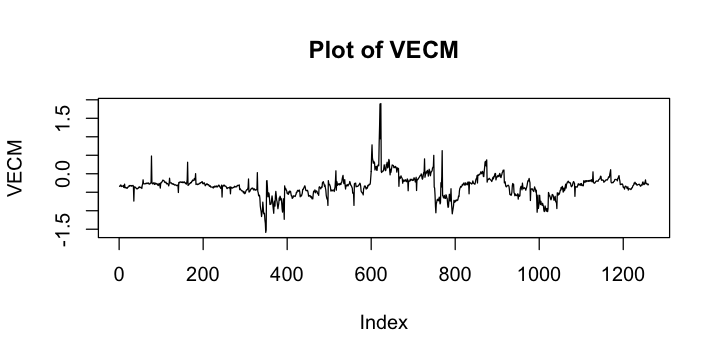

In [11]:
# Plot the time series
options(repr.plot.height=3, repr.plot.width=6)
plot(vecm,type='l',ylab='VECM',main='Plot of VECM')

Figure 2. VECM plot formed from CL1, CL2, and CL3 end of day price time series

Visually this looks like a stationary time series, we import the Augmented Dickey-Fuller (ADF) test as an additional check:

In [12]:
adfRes<- adf.test(vecm)
adfRes


	Augmented Dickey-Fuller Test

data:  vecm
Dickey-Fuller = -3.8672, Lag order = 10, p-value = 0.01563
alternative hypothesis: stationary


Table 4. ADF test results of VECM

* The p-value of VECM is $0.01<0.01563<0.05$, we can conclude the VECM is staionary with 95% confidence interval.

* Therefore ADF test result is consistent with the visually look, i.e., the VECM formed from linear combination with coefficients from Johansen trace conintegration test is stationary.

#### Find the cointegration matrix $a \in \text{Mat}_{n,r}$

* Since the rank $r=1$, we can use linear regression to find the vector $a_{3,1}$

In [13]:
# Linear regression of CL1 regress on CL2 and CL3 with constant term
OLS<- lm(df_CLs[,'CL1_PX_LAST']~df_CLs[,'CL2_PX_LAST']+df_CLs[,'CL3_PX_LAST'])
OLS$coefficients

(Intercept) df_CLs[, "CL2_PX_LAST"] df_CLs[, "CL3_PX_LAST"] 
             -0.2396205               1.8786879              -0.8772706

From OLS results we can get the vector $a_{3,1}=(1,-1.87868790014297,0.877270561522235)^T$. 

Therefore, we can test "cointegrating residual process" $u_t=a^T(\text{CL1,CL2,CL3})^T$

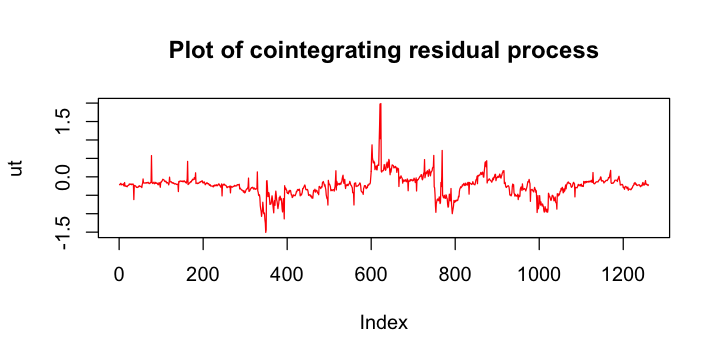

In [14]:
# Cointegrating residual process
ut<- 1*df_CLs[,'CL1_PX_LAST'] -1.87868790014297*df_CLs[,'CL2_PX_LAST'] +
0.877270561522235*df_CLs[,'CL3_PX_LAST']
# Plot the data of ut
options(repr.plot.height=3, repr.plot.width=6)
plot(ut,type='l',col='red',ylab='ut',main='Plot of cointegrating residual process')

Figure 3. Cointegrating residual process plot of three time series premultiply by the transpose of cointegration matrix ($a^T$)

**Observation:**
* The plot looks very close to VECM and looks like stationary, we import Augmented Dickey-Fuller (ADF) as additional check:

In [15]:
adf_ut<-adf.test(ut)
adf_ut


	Augmented Dickey-Fuller Test

data:  ut
Dickey-Fuller = -3.8535, Lag order = 10, p-value = 0.01632
alternative hypothesis: stationary


Table 5. The ADF result of "cointegrating residual process"

* The p-value of VECM is $0.01<0.01632<0.05$, we can conclude the cointegration residual process is staionary with 95% confidence interval.

* The result is very close to the ADF test of VECM

### Final results of Q1

* The largest eigenvalue is 0.027955783
<br><br>

* VECM formed from linear combination of CL1_PX_LAST, CL2_PX_LAST, CL3_PXLAST is stationary with 95% conficence interval.
<br><br>

* The cointegration matrix is $a_{3,1}=(1,-1.87868790014297,0.877270561522235)^T$, which is close to the coefficients of VECM. And the "cointegrating residual process" is stationary with 95% confidence interval.
<br><br>

* Therefore, three front crude oil future contracts has conintegration with rank = 1 and cointeration matrix $a_{3,1}=(1,-1.87868790014297,0.877270561522235)^T$.


In [16]:
# End recording the running time
cat('The running time of this notebooks is:')
proc.time()-ptm

The running time of this notebooks is:

   user  system elapsed 
  1.187   0.081   1.521 